In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND = tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
# import networkx as nx # draw graph vertex & edge
# import pydub # audio
# from numpy.fft import fft, ifft, irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.callbacks import History
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

# for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

import matplotlib.image as mpimg # import image file

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [2]:
split_line_input = Input(shape = (None, None, 1), name = 'split_line_input')
layer = Conv2D(2, (8, 8), padding = 'same', trainable = False, activation = 'relu', name = 'split_line_c1')
z = layer(split_line_input)

### setting weights
w = layer.get_weights()
# print(w[0].shape)
w[0][:, :, 0, 0] = np.ones_like(w[0][:, :, 0, 0])
w[0][w[0].shape[0] // 2:, :, 0, 0] = np.ones_like(w[0][w[0].shape[0] // 2:, :, 0, 0]) * (-1)
w[0][:, :, 0, 1] = np.ones_like(w[0][:, :, 0, 1]) * (-1)
w[0][w[0].shape[0] // 2:, :, 0, 1] = np.ones_like(w[0][w[0].shape[0] // 2:, :, 0, 1])
# w[0][:, :, 0, 2] = np.ones_like(w[0][:, :, 0, 2])
# w[0][:, w[0].shape[0] // 2:, 0, 2] = np.ones_like(w[0][:, w[0].shape[0] // 2:, 0, 2]) * (-1)
# w[0][:, :, 0, 3] = np.ones_like(w[0][:, :, 0, 3]) * (-1)
# w[0][:, w[0].shape[0] // 2:, 0, 3] = np.ones_like(w[0][:, w[0].shape[0] // 2:, 0, 3])
w[1] = np.zeros_like(w[1])
layer.set_weights(w)
# print(layer.get_weights())


# split_line_sum_horizontal = Lambda(lambda v: K.sum(v[:, :, 0:2], axis = 1), name = 'split_line_sum_horizontal')(z)
# split_line_sum_vertical = Lambda(lambda v: K.sum(v[:, :, 2:4], axis = 0), name = 'split_line_sum_vertical')(z)
# z = concatenate([discriminator_audio_output, discriminator_fourier_output], name = 'split_line_concatenate')

split_line_model = Model(split_line_input, z, name = 'split_line_model')
print(split_line_model.summary())

def crop_array_image(img, *rects):
    y = img.shape[0]
    x = img.shape[1]
    startx, starty, cropx, cropy = rects
    endx = min(startx + cropx, x)
    endy = min(starty + cropy, y)
    return img[starty:endy, startx:endx]

def increase_contrast_function(x, s = 0.2, e = 0.8):
    if x < s:
        return 0.
    if x > e:
        return 1.
    x -= s
    x *= e - s
    return -2 * x**3 + 3 * x**2

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
split_line_input (InputLayer (None, None, None, 1)     0         
_________________________________________________________________
split_line_c1 (Conv2D)       (None, None, None, 2)     130       
Total params: 130
Trainable params: 0
Non-trainable params: 130
_________________________________________________________________
None


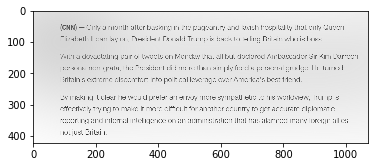

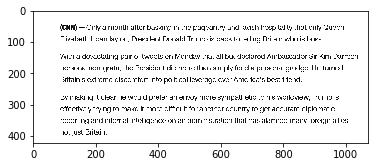

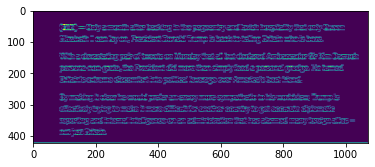

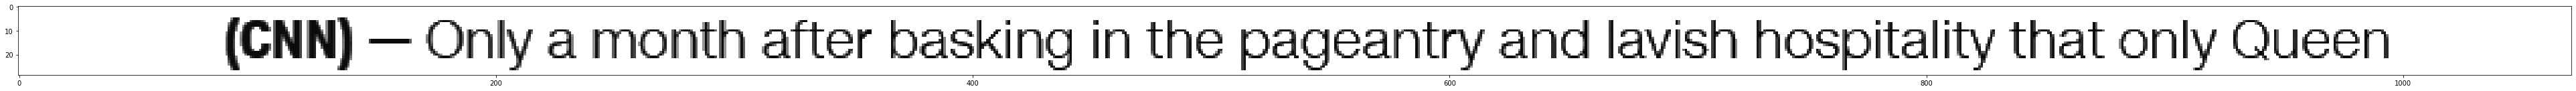

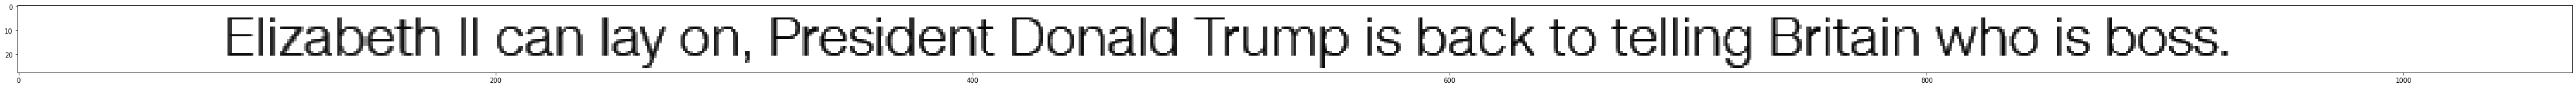

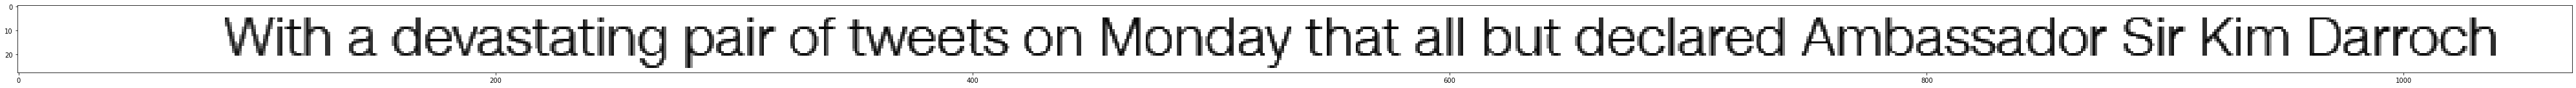

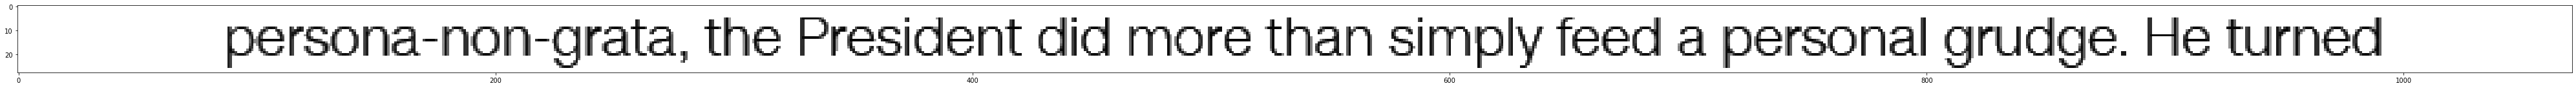

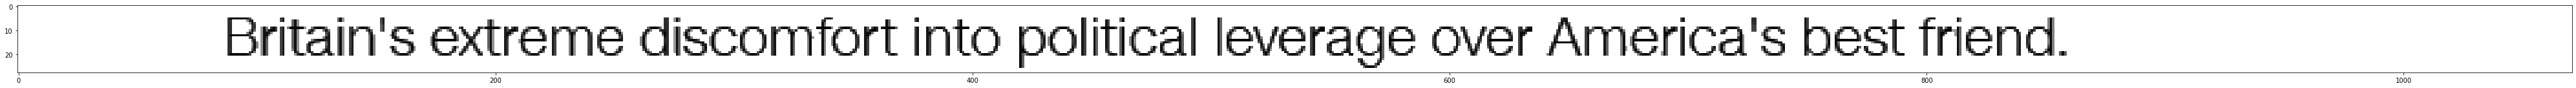

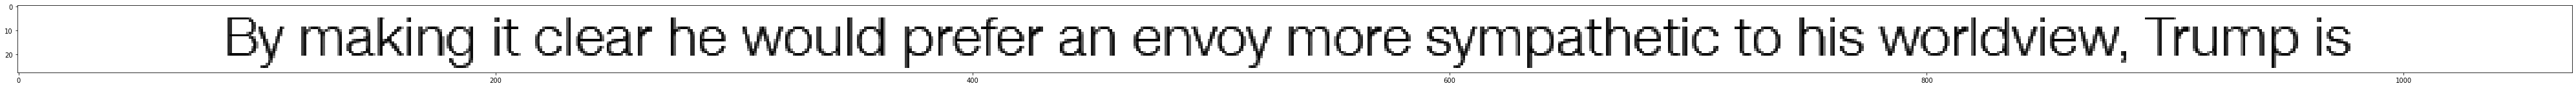

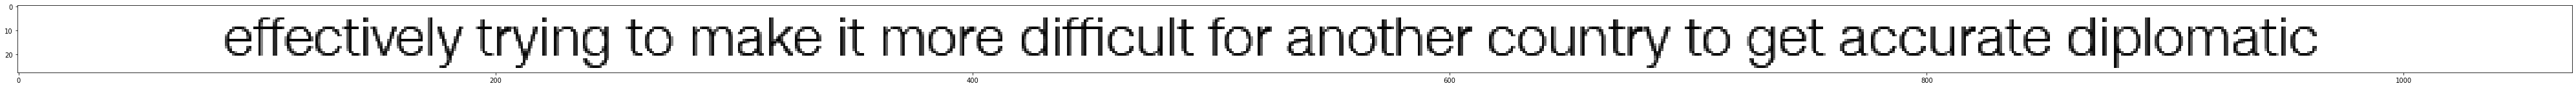

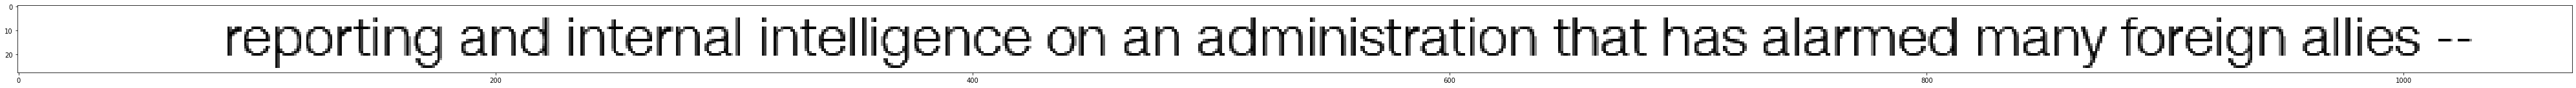

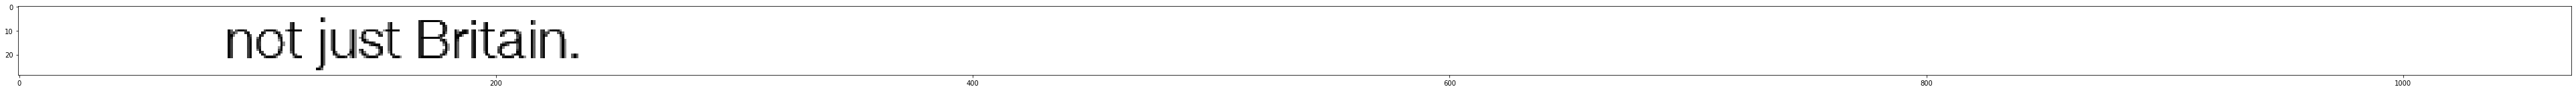

In [3]:
img_png_0 = mpimg.imread("image_test/line_test.png")
plt.imshow(img_png_0)
height, width , _ = img_png_0.shape
plt.show()
# print(img_png)

####### increase contrast #######
img_png = np.vectorize(increase_contrast_function)(img_png_0)
plt.imshow(img_png)
plt.show()
img_png = np.average(img_png, axis = 2)
img_png = img_png * 2 - 1

predicts = split_line_model.predict(img_png.reshape(1, *(img_png.shape), 1))
# print(predicts[0].shape)
A = np.average(predicts[0, :, :, 0:2], axis = 2)
plt.imshow(A)
# plt.imshow(np.average(predicts[0, :, :, 2:4], axis = 2))
# plt.show()
plt.show()

B = np.max(A, axis = 1)
B = np.array([1. if B[i] > 0.2 else 0. for i in range(len(B))])
varlist = [i for i in range(len(B)-1) if abs(B[i] - B[i + 1]) > 0.5]
if varlist[0] < height * 0.01:
    varlist.pop(0)
if len(varlist) % 2 == 1:
    varlist.pop(-1)
rectlist = [[0, varlist[2 * i], width, varlist[2 * i + 1] - varlist[2 * i]] for i in range(len(varlist) // 2)]
# B = np.array([B] * predicts[0].shape[1]).T
# plt.imshow(B)
# plt.show()

for rect in rectlist:
    C = (crop_array_image(np.array([img_png] * 3).transpose(1, 2, 0), *rect) * 255).astype(np.uint8)
    fig, ax = plt.subplots(figsize=(100, 2))
    ax.imshow(C, interpolation='nearest')
    plt.tight_layout()